# Настройка среды

In [1]:
import os
import sys

### Yandex Datasphere
sys.path.append(os.path.abspath(".."))

### Google Colab
# !git clone https://github.com/Belashov641618/OpticalEncoder.git
# sys.path.append(os.path.abspath("OpticalEncoder"))

In [2]:
# %cd OpticalEncoder
# !dir
# !git pull

In [3]:
# %pip install belashovplot
# %pip install optuna
# %pip install timm

In [4]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from utilities.training import train, confusion
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
from pickle import dump
import torch
import numpy
import optuna
import timm
import pickle

C:\Users\uclap\Documents\Coding\Python\OpticalEncoder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FigureWidthHeight = (16, 16)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA GeForce RTX 3060 Ti


# Оптимизиция при оптимальной дистанции распространения

## Установка не изменяемых параметров

In [7]:
# Предпочтительные параметры
size = 50.0E-6
near_N = 300
near_length = 5.0E-3
wavelength = 500.0E-9
optuna_epochs = 1

# Параметры когерентности
spatial_coherence = 50.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 7

# Вычисляемые параметры
pixels = upper_integer(near_length/size)
length = pixels * size

cppp = upper_integer(near_N * size / length)
N = int(length / size) * cppp

reference_distance = length * sqrt((size/wavelength)**2 - 1)

## Инициализация некогерентной обёртки

In [8]:
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length).to(device)

In [9]:
autocorr = autocorrelation(incoherent.sample(), dims=[1,2], mean_dim=0, split=mean_samples)

In [10]:
autocorr_radius, _ = correlation_circle(autocorr, limits=((-length/2,+length/2),(-length/2,+length/2)), percent=0.8)
incoherent_distribution, incoherent_distribution_values = distribution(incoherent.sample(), N=100, return_values=True)
incoherent_sample = incoherent.sample()[0].cpu()
print('Радиус автокорреляции:', engineering(autocorr_radius, 'м'))

Радиус автокорреляции: 16.722 мкм


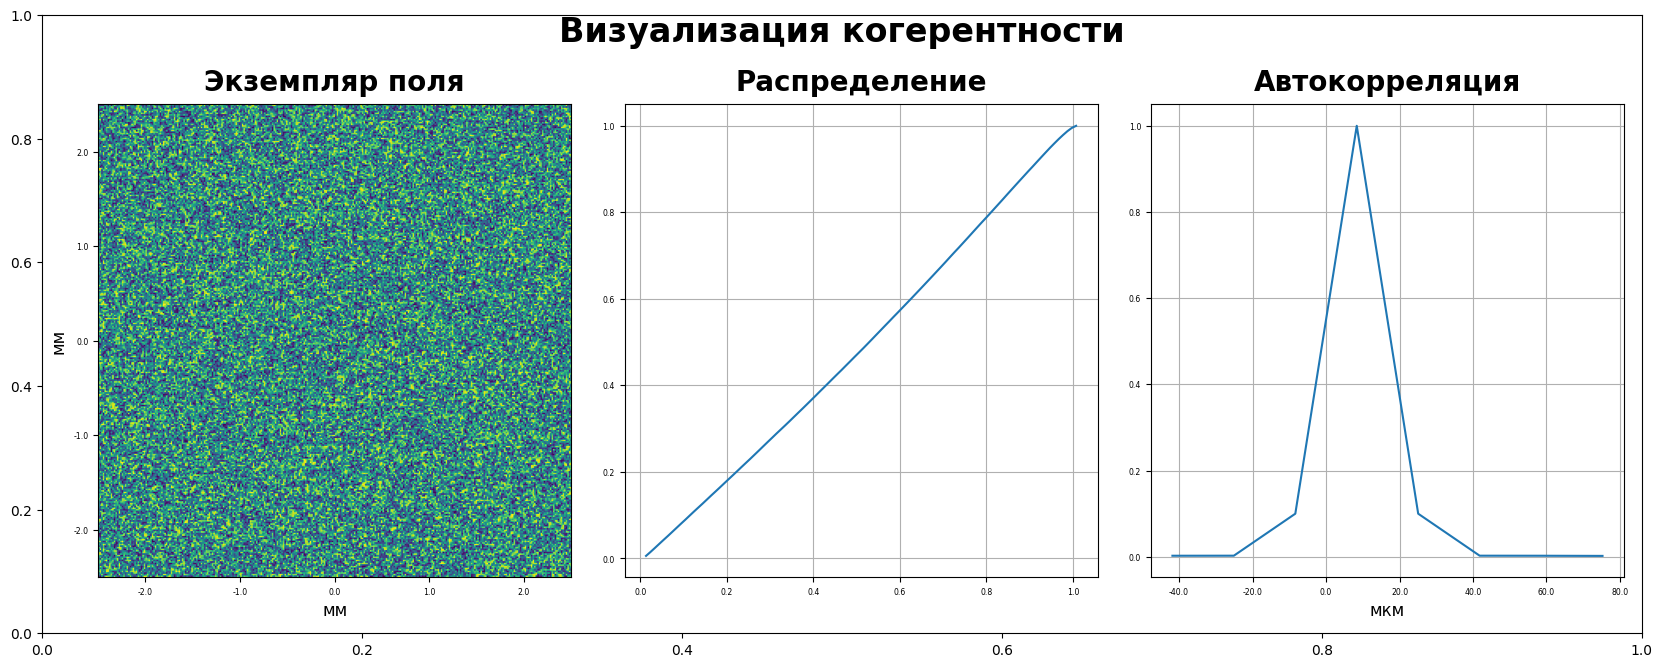

In [11]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title('Визуализация когерентности')

formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')
formatter_rad, unit_rad = engineering.separatedformatter(autocorr_radius, 'м')

axes = plot.axes.add(0,0)
axes.imshow(incoherent_sample, aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)
plot.graph.title('Экземпляр поля')

axes = plot.axes.add(1,0)
axes.grid(True)
axes.plot(incoherent_distribution_values, incoherent_distribution.cpu())
plot.graph.title('Распределение')

p0 = int(autocorr.shape[1]*(1 - 4*autocorr_radius/length)/2)
p1 = p0 + int(8*autocorr.shape[1]*autocorr_radius/length)
axes = plot.axes.add(2,0)
axes.grid(True)
axes.plot(numpy.linspace(-length/2, +length/2, autocorr.shape[1])[p0:p1], autocorr[autocorr.shape[0]//2][p0:p1]/autocorr.max())
axes.xaxis.set_major_formatter(formatter_rad)
plot.graph.label.x(unit_rad)
plot.graph.title('Автокорреляция')

plot.show()

## Инициализация детекторов

In [12]:
detectors_amount = 24
detector_size = length / 60

spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
detectors_filter = Gaussian((detector_size, detector_size), (0,0))
detectors = MatrixDetectors(N, length, wavelength, detectors_amount, detectors_filter, spectral_filter).to(device)

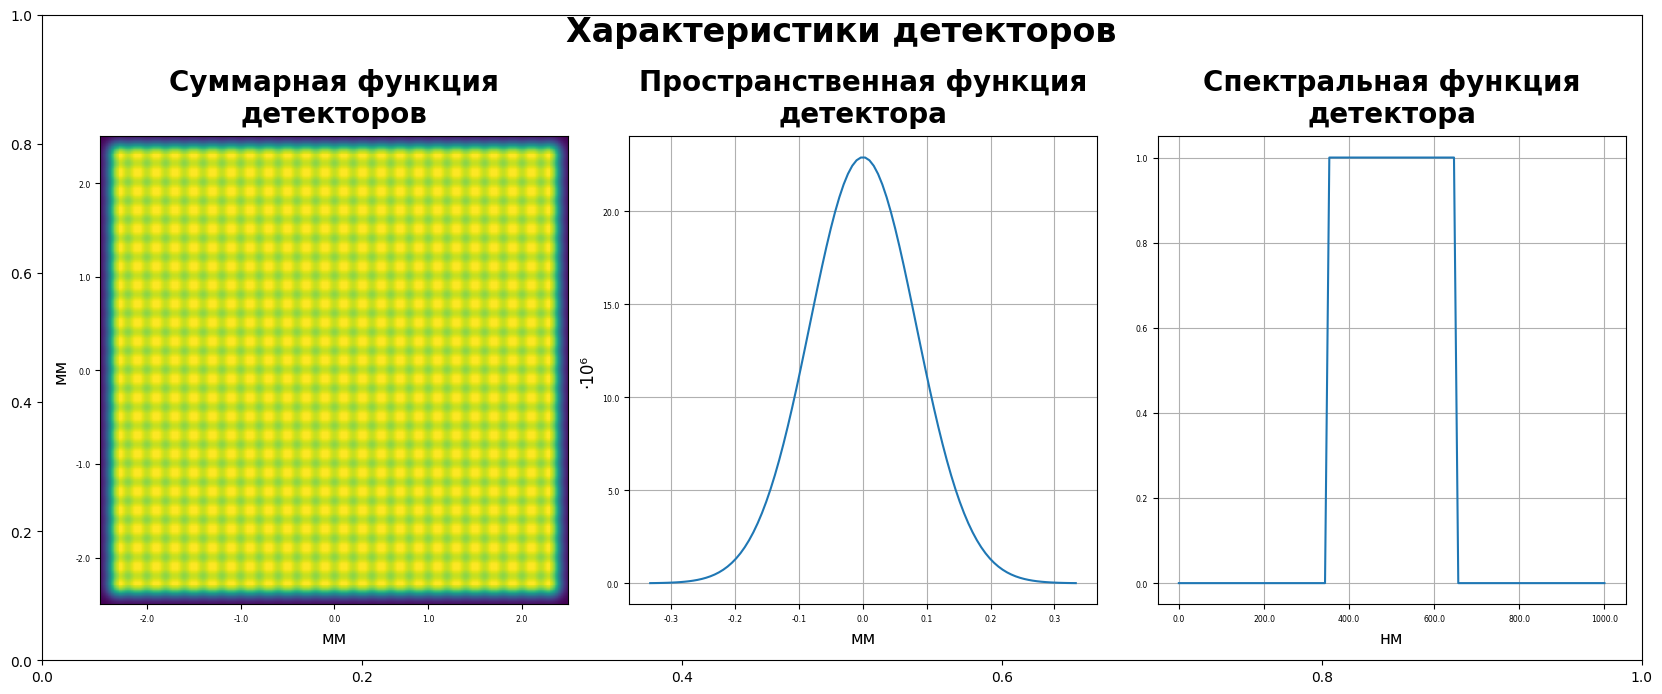

In [13]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.pad.graph.horizontal(0.1)
plot.title('Характеристики детекторов')

x_linspace = torch.linspace(-4*detector_size,+4*detector_size,100)
y_linspace = detectors_filter(x_linspace, x_linspace)[50]
wl_linspace = torch.linspace(0, 1000.0E-9, 100)
s_linspace = spectral_filter(wl_linspace)
formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')
formatter_d, unit_d = scientific.separatedformatter(y_linspace.max(), '')
formatter_wl, unit_wl = engineering.separatedformatter(wl_linspace.max(), 'м')

axes = plot.axes.add(0,0)
axes.imshow(detectors.filter, aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)
plot.graph.title('Суммарная функция детекторов')

axes = plot.axes.add(1,0)
axes.grid(True)
axes.plot(x_linspace, y_linspace)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_d)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_d)
plot.graph.title('Пространственная функция детектора')

axes = plot.axes.add(2,0)
axes.grid(True)
axes.plot(wl_linspace, s_linspace)
axes.xaxis.set_major_formatter(formatter_wl)
plot.graph.label.x(unit_wl)
plot.graph.title('Спектральная функция детектора')

plot.show()

## Инициализация электронной части

In [14]:
electronic = timm.create_model('resnet18', pretrained=True,  in_chans=1, num_classes=10).to(device)

## Комбинированная функция 

In [15]:
def combined_loss(cross_entropy_to_mse_proportion:float=1.0):
    def loss_function(outputs, targets):
        CELoss = torch.nn.functional.cross_entropy(outputs, targets)
        MSELoss = torch.nn.functional.mse_loss(torch.nn.functional.softmax(outputs, dim=1), torch.nn.functional.one_hot(targets, num_classes=10).float())
        loss = cross_entropy_to_mse_proportion*CELoss + (1.0-cross_entropy_to_mse_proportion)*MSELoss
        return loss
    return loss_function

## Выбор диапазона раcстояния распространения

In [16]:
# Настройка диапазона
distance_left_multiplier = 0.05
distance_right_multiplier = 0.5

slices = 100
distance_samples = 4
distance_array = numpy.linspace(reference_distance*distance_left_multiplier, reference_distance*distance_right_multiplier, distance_samples)

In [17]:
different_distance_propagations = []
# Вычисления
initial = torch.zeros((1, 1, N, N), device=device, dtype=torch.complex64)
p0 = N//2 - int(N*size/(length*2))
p1 = p0 + int(N*size/length)
initial[0,0,p0:p1,p0:p1] = 1.0

chunker = CudaMemoryChunker().to(device) 
with torch.no_grad():
    for max_distance in tqdm(distance_array):
        result = torch.zeros((slices, N), dtype=torch.float32)
        for i, distance in enumerate(numpy.linspace(0, max_distance, slices)):
            propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance).to(device)
            chunker.attach_forward(propagation.forward)
            incoherent.attach_forward(chunker.forward)
            result[i] = incoherent.forward(initial)[0,0,N//2].abs().cpu()
        different_distance_propagations.append((max_distance, result))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.30s/it]


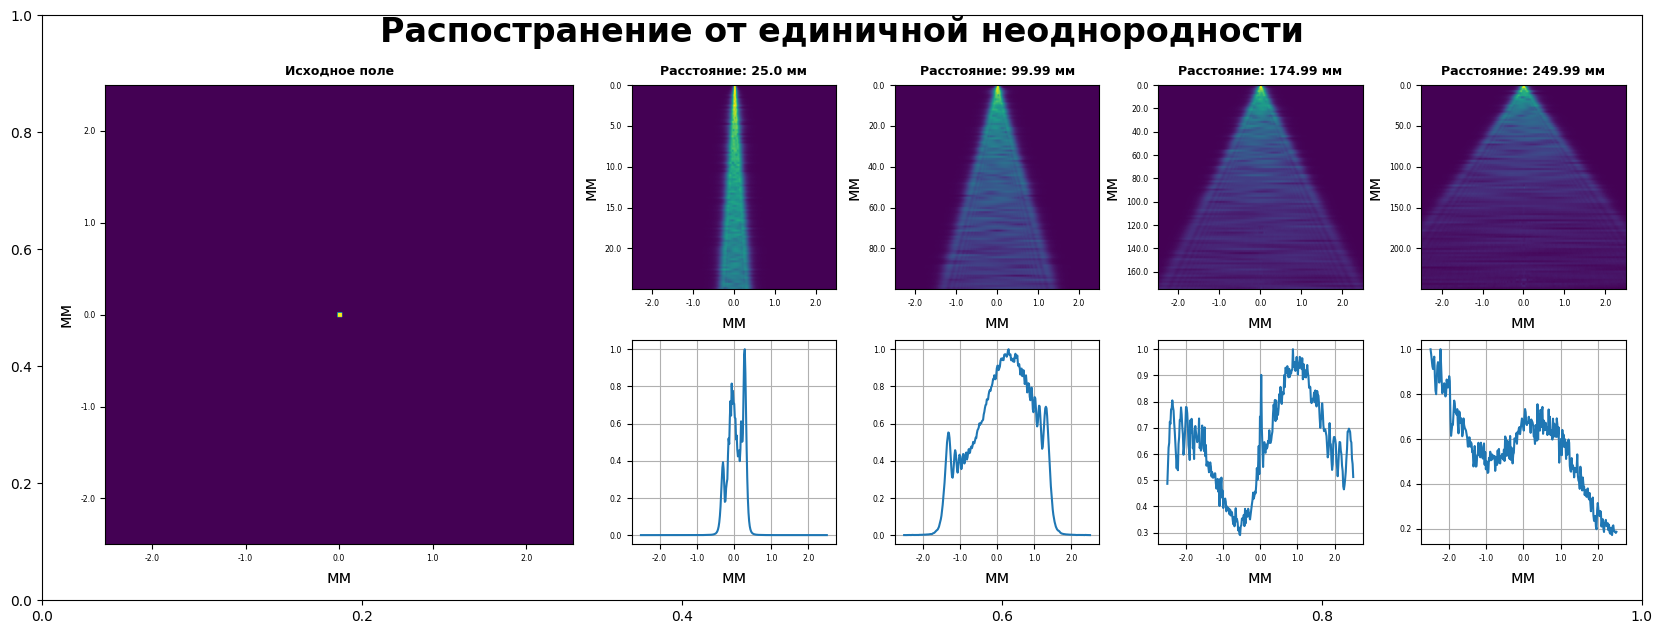

In [18]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title('Распостранение от единичной неоднородности')

formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')

axes = plot.axes.add((0,0),(1,1))
axes.imshow(initial[0][0].abs().cpu(), aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)

plot.description.column.top('Исходное поле',0,1)

for col, (distance, data) in enumerate(different_distance_propagations, 2):
    formatter_z, unit_z = engineering.separatedformatter(distance, 'м')
    plot.description.column.top(f"Расстояние: {engineering(distance,'м', 2)}", col)
    
    axes = plot.axes.add(col, 0)
    axes.imshow(torch.log10(data+0.0001), aspect='auto', extent=[-length/2,+length/2,distance,0])
    axes.xaxis.set_major_formatter(formatter_xy)
    axes.yaxis.set_major_formatter(formatter_z)
    plot.graph.label.x(unit_xy)
    plot.graph.label.y(unit_z)

    axes = plot.axes.add(col,1)
    axes.grid(True)
    axes.plot(numpy.linspace(-length/2,+length/2,N), data[-1]/data[-1].max())
    axes.xaxis.set_major_formatter(formatter_xy)
    plot.graph.label.x(unit_xy)

plot.show()

## Вариации изменяемых параметров

In [19]:
# Установить вручную по картинкам выше (чем больше покрытие и меньше шумов, тем лучше)
distance_limits = (80.0E-3, 180.0E-3)

In [20]:
masks_amount_limits = (3, 10)
batch_size_limits = (20, 50)
learning_rate_limits = (0.00001, 0.1)
loss_functions_proportion_limits = (0.0, 1.0)
optimizer_types_list = {'Adam':torch.optim.Adam, 'SGD':torch.optim.SGD, 'RMSprop':torch.optim.RMSprop, 'Adagrad':torch.optim.Adagrad}

## Вывод окончательных параметров

In [21]:
print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(size, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")

print(f"Временная когерентность:                  {engineering(time_coherence, 'с')}")
print(f"Время релаксации:                         {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность:           {engineering(spatial_coherence, 'м')}")
print(f"Количество усреднений:                    {mean_samples}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       300
Количество пикселей маски:                100
Размер оптических элементов:              5.0 мм
Размер пикселя маски:                     50.0 мкм
Расстояние между слоями:                  249.987 мм
Временная когерентность:                  10.0 нс
Время релаксации:                         1.0 мкc
Пространственная когерентность:           50.0 мкм
Количество усреднений:                    7


## Функция цели для optuna и оптимизация

In [22]:
def objective(trial:optuna.trial):
    masks_amount = trial.suggest_int('masks amount', *masks_amount_limits)
    batch_size = trial.suggest_int('batch size', *batch_size_limits)
    distance = trial.suggest_float('distance', *distance_limits)
    learning_rate = trial.suggest_float('learning rate', *learning_rate_limits, log=True)
    loss_functions_proportion = trial.suggest_float('cross entorpy proportion', *loss_functions_proportion_limits)
    optimizer_type = trial.suggest_categorical('optimizer type', optimizer_types_list.keys())

    print('Эксперимент:')
    print(f"\tКоличетсво масок:  {masks_amount}")
    print(f"\tРазмер батча:      {batch_size}")
    print(f"\tДистанция:         {engineering(distance, 'м')}")
    print(f"\tСкорость обучения: {learning_rate}")
    print(f"\tПропорция CELoss:  {loss_functions_proportion}")
    print(f"\tТип оптимизатора:  {optimizer_type}")
    
    # Инициализация оптической части и гибридной модели
    propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.4)
    phase_modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
    amplitude_modulators = [AmplitudeModulator(N, length, pixels) for i in range(masks_amount)]
    elements = [phase_modulators[0], amplitude_modulators[0]]
    for phase_modulator, amplitude_modulator in zip(phase_modulators[1:], amplitude_modulators[1:]):
        elements.append(propagation)
        elements.append(phase_modulator)
        elements.append(amplitude_modulator)
    elements.append(propagation)
    chunker = CudaMemoryChunker(sub_chunks=mean_samples)
    optical = CompositeModel(*elements)
    optical.wrap(chunker)
    optical.wrap(incoherent)
    optical.to(device)
    model = HybridModel(optical, detectors, electronic)
    
    # Подготовка данных, функции ошибки и оптимизатора
    dataset = Dataset('CIFAR10', batch_size, N, N, torch.complex64)
    dataset.train
    dataset.test
    loss_function = combined_loss(loss_functions_proportion)
    optimizer = optimizer_types_list[optimizer_type](model.parameters(), lr=learning_rate)

    # Обучение модели
    for i in range(optuna_epochs):
        train(model, dataset, optimizer, loss_function)
    confusion_matrix = confusion(model, dataset)
    return 100*numpy.sum(numpy.diagonal(confusion_matrix, 0))/numpy.sum(confusion_matrix)
study = optuna.create_study(study_name="ID2NN", storage="sqlite:///ID2NN.db", direction='maximize', load_if_exists=True)

[I 2024-05-01 23:38:12,372] Using an existing study with name 'ID2NN' instead of creating a new one.


In [23]:
study.optimize(objective, n_trials=5)

Эксперимент:
	Количетсво масок:  9
	Размер батча:      49
	Дистанция:         121.819 мм
	Скорость обучения: 0.00023011169536076617
	Пропорция CELoss:  0.8997427046307435
	Тип оптимизатора:  SGD
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.1194183113599045, RPI1000: -0.002437428945655607: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1021/1021 [52:10<00:00,  3.07s/it]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [01:45<00:00,  1.94it/s]
[I 2024-05-02 00:32:10,661] Trial 31 finished with value: 9.12 and parameters: {'masks amount': 9, 'batch size': 49, 'distance': 0.12181895704793025, 'learning rate': 0.00023011169536076617, 'cross entorpy proportion': 0.8997427046307435, 'optimizer type': 'SGD'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  10
	Размер батча:      38
	Дистанция:         112.825 мм
	Скорость обучения: 0.0037749269875782033
	Пропорция CELoss:  0.9799997473396223
	Тип оптимизатора:  Adagrad
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.2396511167026607, RPI1000: -0.01640396321625784: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [55:41<00:00,  2.54s/it]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [01:55<00:00,  2.28it/s]
[I 2024-05-02 01:29:49,685] Trial 32 finished with value: 10.0 and parameters: {'masks amount': 10, 'batch size': 38, 'distance': 0.11282480382720718, 'learning rate': 0.0037749269875782033, 'cross entorpy proportion': 0.9799997473396223, 'optimizer type': 'Adagrad'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      47
	Дистанция:         99.665 мм
	Скорость обучения: 0.014909850218784314
	Пропорция CELoss:  0.585492925793448
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.3452971311516664, RPI1000: -0.27254387746179193: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1064/1064 [12:33<00:00,  1.41it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [01:11<00:00,  2.98it/s]
[I 2024-05-02 01:43:36,138] Trial 33 finished with value: 12.58 and parameters: {'masks amount': 5, 'batch size': 47, 'distance': 0.09966534944475419, 'learning rate': 0.014909850218784314, 'cross entorpy proportion': 0.585492925793448, 'optimizer type': 'RMSprop'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      48
	Дистанция:         104.345 мм
	Скорость обучения: 0.0177928536458187
	Пропорция CELoss:  0.6819508883529356
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.4896173268603536, RPI1000: -0.09369922299526755: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1042/1042 [13:13<00:00,  1.31it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [01:01<00:00,  3.40it/s]
[I 2024-05-02 01:57:53,435] Trial 34 finished with value: 15.36 and parameters: {'masks amount': 4, 'batch size': 48, 'distance': 0.10434480197513475, 'learning rate': 0.0177928536458187, 'cross entorpy proportion': 0.6819508883529356, 'optimizer type': 'RMSprop'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      43
	Дистанция:         87.802 мм
	Скорость обучения: 0.006763716182185687
	Пропорция CELoss:  0.5187717365678872
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.1718327521498306, RPI1000: -0.04839967485255098: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1163/1163 [10:29<00:00,  1.85it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 233/233 [01:03<00:00,  3.65it/s]
[I 2024-05-02 02:09:28,669] Trial 35 finished with value: 20.48 and parameters: {'masks amount': 5, 'batch size': 43, 'distance': 0.08780208804708639, 'learning rate': 0.006763716182185687, 'cross entorpy proportion': 0.5187717365678872, 'optimizer type': 'RMSprop'}. Best is trial 2 with value: 22.12.


In [24]:
study.optimize(objective, n_trials=5)

Эксперимент:
	Количетсво масок:  4
	Размер батча:      43
	Дистанция:         86.24 мм
	Скорость обучения: 0.054902516522355164
	Пропорция CELoss:  0.42438241071476934
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.9660342445399868, RPI1000: -0.41146199518473103: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1163/1163 [08:38<00:00,  2.24it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 233/233 [00:56<00:00,  4.14it/s]
[I 2024-05-02 02:19:05,218] Trial 36 finished with value: 14.25 and parameters: {'masks amount': 4, 'batch size': 43, 'distance': 0.08624015719027166, 'learning rate': 0.054902516522355164, 'cross entorpy proportion': 0.42438241071476934, 'optimizer type': 'RMSprop'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      42
	Дистанция:         95.52 мм
	Скорость обучения: 0.008399522375363613
	Пропорция CELoss:  0.5342346046640614
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.1669344781049122, RPI1000: -0.025009831027221492: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1191/1191 [07:47<00:00,  2.55it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [00:53<00:00,  4.44it/s]
[I 2024-05-02 02:27:48,293] Trial 37 finished with value: 16.46 and parameters: {'masks amount': 3, 'batch size': 42, 'distance': 0.09552020432066943, 'learning rate': 0.008399522375363613, 'cross entorpy proportion': 0.5342346046640614, 'optimizer type': 'RMSprop'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      35
	Дистанция:         88.312 мм
	Скорость обучения: 0.026041863449787095
	Пропорция CELoss:  0.7176314971882554
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.494670919033067, RPI1000: -0.10361701140580853: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [08:48<00:00,  2.70it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:54<00:00,  5.22it/s]
[I 2024-05-02 02:37:33,656] Trial 38 finished with value: 19.44 and parameters: {'masks amount': 4, 'batch size': 35, 'distance': 0.08831163683529909, 'learning rate': 0.026041863449787095, 'cross entorpy proportion': 0.7176314971882554, 'optimizer type': 'RMSprop'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      45
	Дистанция:         84.012 мм
	Скорость обучения: 0.0050485727408864055
	Пропорция CELoss:  0.3579278045521339
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.7859094877984423, RPI1000: -0.02424193623434477: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1112/1112 [08:59<00:00,  2.06it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 223/223 [00:59<00:00,  3.78it/s]
[I 2024-05-02 02:47:34,182] Trial 39 finished with value: 19.15 and parameters: {'masks amount': 4, 'batch size': 45, 'distance': 0.0840115363043919, 'learning rate': 0.0050485727408864055, 'cross entorpy proportion': 0.3579278045521339, 'optimizer type': 'RMSprop'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      38
	Дистанция:         116.627 мм
	Скорость обучения: 0.00215026080119832
	Пропорция CELoss:  0.08663036721217032
	Тип оптимизатора:  Adagrad
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.2741955299561556, RPI1000: -0.004548410233442103: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [10:32<00:00,  2.08it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [01:07<00:00,  3.91it/s]
[I 2024-05-02 02:59:15,863] Trial 40 finished with value: 17.53 and parameters: {'masks amount': 5, 'batch size': 38, 'distance': 0.11662739135405994, 'learning rate': 0.00215026080119832, 'cross entorpy proportion': 0.08663036721217032, 'optimizer type': 'Adagrad'}. Best is trial 2 with value: 22.12.


In [25]:
study.optimize(objective, n_trials=5)

Эксперимент:
	Количетсво масок:  6
	Размер батча:      43
	Дистанция:         127.669 мм
	Скорость обучения: 2.3162607993923998e-05
	Пропорция CELoss:  0.8050189103383198
	Тип оптимизатора:  SGD
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.0440742249500237, RPI1000: -0.0012381473929806593: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1163/1163 [29:13<00:00,  1.51s/it]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 233/233 [01:13<00:00,  3.15it/s]
[I 2024-05-02 03:29:45,756] Trial 41 finished with value: 11.9 and parameters: {'masks amount': 6, 'batch size': 43, 'distance': 0.12766942864922026, 'learning rate': 2.3162607993923998e-05, 'cross entorpy proportion': 0.8050189103383198, 'optimizer type': 'SGD'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      45
	Дистанция:         91.97 мм
	Скорость обучения: 1.1146713214356776e-05
	Пропорция CELoss:  0.616836995156932
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.5524388274260084, RPI1000: -0.009526647314416499: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1112/1112 [07:16<00:00,  2.55it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 223/223 [00:48<00:00,  4.62it/s]
[I 2024-05-02 03:37:52,716] Trial 42 finished with value: 18.55 and parameters: {'masks amount': 3, 'batch size': 45, 'distance': 0.09197014854327695, 'learning rate': 1.1146713214356776e-05, 'cross entorpy proportion': 0.616836995156932, 'optimizer type': 'RMSprop'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      35
	Дистанция:         88.617 мм
	Скорость обучения: 0.024822663387387724
	Пропорция CELoss:  0.7150803899846535
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.5842804024885722, RPI1000: -0.053858547930516455: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [08:49<00:00,  2.70it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:54<00:00,  5.24it/s]
[I 2024-05-02 03:47:38,526] Trial 43 finished with value: 20.15 and parameters: {'masks amount': 4, 'batch size': 35, 'distance': 0.08861658675557967, 'learning rate': 0.024822663387387724, 'cross entorpy proportion': 0.7150803899846535, 'optimizer type': 'RMSprop'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      28
	Дистанция:         96.84 мм
	Скорость обучения: 0.07589384928443416
	Пропорция CELoss:  0.7244868581537922
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.7052343460493693, RPI1000: -0.09472903874192289: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1786/1786 [09:29<00:00,  3.13it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 358/358 [00:55<00:00,  6.50it/s]
[I 2024-05-02 03:58:05,286] Trial 44 finished with value: 10.0 and parameters: {'masks amount': 4, 'batch size': 28, 'distance': 0.09684033108011314, 'learning rate': 0.07589384928443416, 'cross entorpy proportion': 0.7244868581537922, 'optimizer type': 'RMSprop'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      33
	Дистанция:         84.188 мм
	Скорость обучения: 0.037686959937795195
	Пропорция CELoss:  0.7593327983112385
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.7673760085738293, RPI1000: -0.009034227404731452: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1516/1516 [10:14<00:00,  2.47it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 304/304 [01:02<00:00,  4.87it/s]
[I 2024-05-02 04:09:24,057] Trial 45 finished with value: 10.0 and parameters: {'masks amount': 5, 'batch size': 33, 'distance': 0.08418773364978324, 'learning rate': 0.037686959937795195, 'cross entorpy proportion': 0.7593327983112385, 'optimizer type': 'RMSprop'}. Best is trial 2 with value: 22.12.


In [26]:
study.optimize(objective, n_trials=5)

Эксперимент:
	Количетсво масок:  3
	Размер батча:      36
	Дистанция:         90.003 мм
	Скорость обучения: 0.022785082100263074
	Пропорция CELoss:  0.6422308802342724
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.5142488702204058, RPI1000: -0.0006603055802945169: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [07:42<00:00,  3.00it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [02:00<00:00,  2.30it/s]
[I 2024-05-02 04:19:09,637] Trial 46 finished with value: 10.0 and parameters: {'masks amount': 3, 'batch size': 36, 'distance': 0.09000269215159373, 'learning rate': 0.022785082100263074, 'cross entorpy proportion': 0.6422308802342724, 'optimizer type': 'RMSprop'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      31
	Дистанция:         97.075 мм
	Скорость обучения: 0.06534861138615827
	Пропорция CELoss:  0.46110641864061247
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.1148062965786174, RPI1000: -0.0016203003967322268: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1613/1613 [08:41<00:00,  3.09it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [01:05<00:00,  4.94it/s]
[I 2024-05-02 04:28:58,495] Trial 47 finished with value: 10.0 and parameters: {'masks amount': 3, 'batch size': 31, 'distance': 0.09707534041704889, 'learning rate': 0.06534861138615827, 'cross entorpy proportion': 0.46110641864061247, 'optimizer type': 'Adam'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      27
	Дистанция:         139.578 мм
	Скорость обучения: 0.0013024723567391064
	Пропорция CELoss:  0.8634185920852113
	Тип оптимизатора:  SGD
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9985646136064108, RPI1000: -0.0005138803811456811: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1852/1852 [10:20<00:00,  2.99it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 371/371 [00:57<00:00,  6.46it/s]
[I 2024-05-02 04:40:18,155] Trial 48 finished with value: 10.0 and parameters: {'masks amount': 5, 'batch size': 27, 'distance': 0.1395775069192886, 'learning rate': 0.0013024723567391064, 'cross entorpy proportion': 0.8634185920852113, 'optimizer type': 'SGD'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      39
	Дистанция:         109.296 мм
	Скорость обучения: 0.0075205571813467655
	Пропорция CELoss:  0.558525795766567
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.3288527946579447, RPI1000: -0.0003235115577991536: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1283/1283 [08:44<00:00,  2.45it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 257/257 [00:56<00:00,  4.55it/s]
[I 2024-05-02 04:50:01,173] Trial 49 finished with value: 10.0 and parameters: {'masks amount': 4, 'batch size': 39, 'distance': 0.10929638034036293, 'learning rate': 0.0075205571813467655, 'cross entorpy proportion': 0.558525795766567, 'optimizer type': 'RMSprop'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      36
	Дистанция:         83.998 мм
	Скорость обучения: 0.03638508684252487
	Пропорция CELoss:  0.6901088030514755
	Тип оптимизатора:  Adagrad
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.617436954952075, RPI1000: -0.0003298186408727918: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [11:31<00:00,  2.01it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [02:05<00:00,  2.22it/s]
[I 2024-05-02 05:03:39,873] Trial 50 finished with value: 10.0 and parameters: {'masks amount': 6, 'batch size': 36, 'distance': 0.08399751558926752, 'learning rate': 0.03638508684252487, 'cross entorpy proportion': 0.6901088030514755, 'optimizer type': 'Adagrad'}. Best is trial 2 with value: 22.12.


In [27]:
study.optimize(objective, n_trials=5)

Эксперимент:
	Количетсво масок:  4
	Размер батча:      41
	Дистанция:         91.179 мм
	Скорость обучения: 0.01992296835092949
	Пропорция CELoss:  0.2061447681211509
	Тип оптимизатора:  SGD
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.5461622156261361, RPI1000: 5.0224765030721865e-06: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1220/1220 [13:41<00:00,  1.48it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [01:00<00:00,  4.02it/s]
[I 2024-05-02 05:18:24,177] Trial 51 finished with value: 10.0 and parameters: {'masks amount': 4, 'batch size': 41, 'distance': 0.09117934859395646, 'learning rate': 0.01992296835092949, 'cross entorpy proportion': 0.2061447681211509, 'optimizer type': 'SGD'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      49
	Дистанция:         173.893 мм
	Скорость обучения: 0.00012079906120142997
	Пропорция CELoss:  0.6249258613448286
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.472718037342326, RPI1000: -4.798774849487571e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1021/1021 [49:37<00:00,  2.92s/it]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [01:27<00:00,  2.33it/s]
[I 2024-05-02 06:09:31,220] Trial 52 finished with value: 10.0 and parameters: {'masks amount': 7, 'batch size': 49, 'distance': 0.1738927118238935, 'learning rate': 0.00012079906120142997, 'cross entorpy proportion': 0.6249258613448286, 'optimizer type': 'RMSprop'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      35
	Дистанция:         87.85 мм
	Скорость обучения: 0.012042771423498163
	Пропорция CELoss:  0.7389262147968977
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.729925953823077, RPI1000: -0.00043083251304599195: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [08:49<00:00,  2.70it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:54<00:00,  5.23it/s]
[I 2024-05-02 06:19:16,984] Trial 53 finished with value: 10.0 and parameters: {'masks amount': 4, 'batch size': 35, 'distance': 0.08784975419679054, 'learning rate': 0.012042771423498163, 'cross entorpy proportion': 0.7389262147968977, 'optimizer type': 'RMSprop'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  3
	Размер батча:      34
	Дистанция:         80.013 мм
	Скорость обучения: 0.025599750336998583
	Пропорция CELoss:  0.8129973978423651
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8944749748169016, RPI1000: -0.0004830473581099725: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1471/1471 [07:19<00:00,  3.34it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295/295 [00:47<00:00,  6.27it/s]
[I 2024-05-02 06:27:25,997] Trial 54 finished with value: 10.0 and parameters: {'masks amount': 3, 'batch size': 34, 'distance': 0.08001338160708639, 'learning rate': 0.025599750336998583, 'cross entorpy proportion': 0.8129973978423651, 'optimizer type': 'RMSprop'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      37
	Дистанция:         99.164 мм
	Скорость обучения: 0.09994330756254927
	Пропорция CELoss:  0.6752231573755602
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.5795838255576427, RPI1000: -0.005295947973013675: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [08:45<00:00,  2.57it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [01:02<00:00,  4.32it/s]
[I 2024-05-02 06:37:15,836] Trial 55 finished with value: 10.0 and parameters: {'masks amount': 4, 'batch size': 37, 'distance': 0.09916394085884273, 'learning rate': 0.09994330756254927, 'cross entorpy proportion': 0.6752231573755602, 'optimizer type': 'RMSprop'}. Best is trial 2 with value: 22.12.


In [ ]:
study.optimize(objective, n_trials=5)

Эксперимент:
	Количетсво масок:  3
	Размер батча:      30
	Дистанция:         87.661 мм
	Скорость обучения: 0.03968286801746399
	Пропорция CELoss:  0.5018812619491058
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.204994509973293, RPI1000: -0.0008268306180903044: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1667/1667 [07:54<00:00,  3.51it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:51<00:00,  6.55it/s]
[I 2024-05-02 06:46:03,583] Trial 56 finished with value: 10.0 and parameters: {'masks amount': 3, 'batch size': 30, 'distance': 0.08766066225363602, 'learning rate': 0.03968286801746399, 'cross entorpy proportion': 0.5018812619491058, 'optimizer type': 'RMSprop'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      44
	Дистанция:         91.431 мм
	Скорость обучения: 0.010531615293998207
	Пропорция CELoss:  0.5564105943758575
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.3203325068120728, RPI1000: -0.0003775300013613233: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1137/1137 [08:37<00:00,  2.20it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [00:54<00:00,  4.18it/s]
[I 2024-05-02 06:55:37,287] Trial 57 finished with value: 10.0 and parameters: {'masks amount': 4, 'batch size': 44, 'distance': 0.09143102382341851, 'learning rate': 0.010531615293998207, 'cross entorpy proportion': 0.5564105943758575, 'optimizer type': 'RMSprop'}. Best is trial 2 with value: 22.12.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      32
	Дистанция:         84.394 мм
	Скорость обучения: 0.005912192850722347
	Пропорция CELoss:  0.7734753146110203
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8028008943313092, RPI1000: -0.0003829305302359409:  63%|████████████████████████████████████████████████████████▎                                 | 978/1563 [07:53<04:27,  2.19it/s]

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
print("Лучшие гиперпараметры:", study.best_trial.params)